In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

2025-01-11 09:52:00.174384: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 09:52:00.388300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736574720.496912     153 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736574720.529425     153 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 09:52:00.771577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
tf.keras.backend.set_floatx("float64")

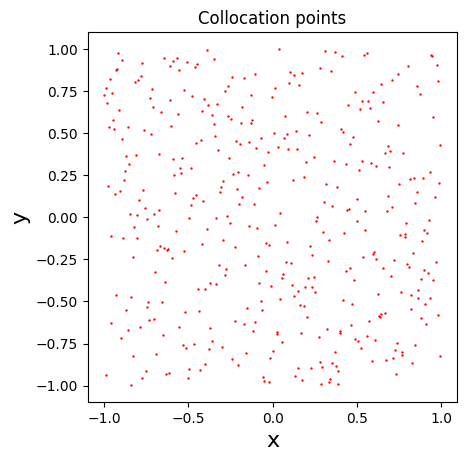

I0000 00:00:1736574752.539028     153 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13717 MB memory:  -> device: 0, name: NVIDIA RTX A5000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# .......................................
# We solve Laplace equation Delta u = 0
#.........................................

### data generation on boundaries are not used here for Lagaris variant ...........
# ...............................................................................

n_bc = 4
n_data_per_bc = 30
#
engine = qmc.LatinHypercube(d=1)
data = np.zeros([n_bc, n_data_per_bc, 3])

for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    if i < 2:
        data[i, :, 0] = j
        data[i, :, 1] = points
    else:
        data[i, :, 0] = points
        data[i, :, 1] = j
    
# BC Values for u ........
# in x BC and y BC
for j in range(0,n_data_per_bc):    
    data[0, j, 2] = - data[0, j, 1]**2 + 1
    data[1, j, 2] = - data[1, j, 1]**2 + 1    
for i in range(0,n_data_per_bc):
    data[2, i, 2] =  data[2, i, 0]**2 - 1
    data[3, i, 2] = data[3, i, 0]**2 - 1

data = data.reshape(n_data_per_bc * n_bc, 3)
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2] ])

#...................................................................
# Collocation data ...............................................
#................................................................
Nc = 400
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 2 * (colloc -0.5)
#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

#
plt.title("Collocation points")
#plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=2., marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
plt.show()

#
x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

In [4]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=5, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [5]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 5, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,761 (13.76 KB)

 Trainable params: 1,761 (13.76 KB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [6]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

# Solution modified to enforce exactly the BC ... see Lagaris Paper ...
@tf.function
def um(x, y):
    x2 = x*x
    y2 = y*y
    um = model(tf.concat([x, y], axis=1))
    #um = (1-x)*(x+1)*(1-y)*(y+1)*um
    um = (1 - x2 - y2 + x2*y2)*um
    #um = um + (1-x)/2*(1-y2) + (1+x)/2*(1-y2) + (1-y)/2 *(x2-1 ) + (1+y)/2 *(x2 - 1)
    um = um + (x2 - y2)
    return um


In [7]:
# Residual equation .. as Delta u = 0 is solved 
#.............................................

@tf.function
def f(x, y):
    u0 = um(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F = u_xx + u_yy    
    return tf.reduce_mean(tf.square(F))

In [8]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))


    0, 1.132616448
  100, 0.002050333
  200, 0.000841010
  300, 0.000332907
  400, 0.000152805
  500, 0.000089745
  600, 0.000065785
  700, 0.000055653
  800, 0.000050783
  900, 0.000047957
 1000, 0.000045901
 1100, 0.000044117
 1200, 0.000042416
 1300, 0.000040735
 1400, 0.000039053
 1500, 0.000037366
 1600, 0.000035673
 1700, 0.000033979
 1800, 0.000032286
 1900, 0.000030638
 2000, 0.000029014
 2100, 0.000027414
 2200, 0.000025838
 2300, 0.000024290
 2400, 0.000022885
 2500, 0.000021357
 2600, 0.000019964
 2700, 0.000018616
 2800, 0.000017315
 2900, 0.000016078
 3000, 0.000014910
 3100, 0.000013797
 3200, 0.000012739
 3300, 0.000011737
 3400, 0.000010835
 3500, 0.000009938
 3600, 0.000009128
 3700, 0.000008372
 3800, 0.000007669
 3900, 0.000007032
 4000, 0.000006447
 4100, 0.000005911
 4200, 0.000005421
 4300, 0.000004977
 4400, 0.000004578
 4500, 0.000004220
 4600, 0.000003898
 4700, 0.000003607
 4800, 0.000003758
 4900, 0.000003120
 5000, 0.000002916
 5100, 0.000002733
 5200, 0.000

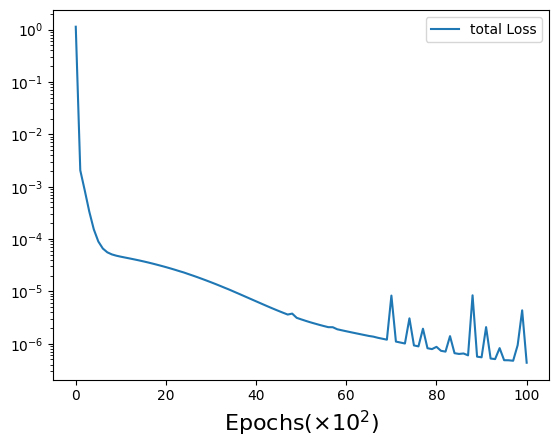

In [9]:
# Training procedure ........
# Only the loss on physics is used .....
# .....................................

loss = 0
#epochs = 62000
epochs = 10000
opt = tf.keras.optimizers.Adam(learning_rate=2e-4)
epoch = 0
loss_values = np.array([])
l_values = np.array([])
L_values = np.array([])
#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        L = f(x_c, y_c)  
        # loss on PDE
        loss = L 
        
        
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    #loss_values = np.append(loss_values, loss)
    #L_values = np.append(L_values, L)
    #l_values = np.append(l_values, l)
    
    if epoch % 100 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.9f}")
        loss_values = np.append(loss_values, loss)
        L_values = np.append(L_values, L)

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
#plt.semilogy(loss_values, label=model.name)
plt.semilogy(loss_values, label='total Loss')
plt.xlabel("Epochs" r'($\times 10^2$)',fontsize=16)
plt.legend()

In [10]:
# Define a grid of points in order to evaluate and plot the solution ....
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])
TT = np.zeros([n, n])


(np.float64(-1.0101010101010102),
 np.float64(1.0101010101010097),
 np.float64(-1.0101010101010102),
 np.float64(1.0101010101010097))

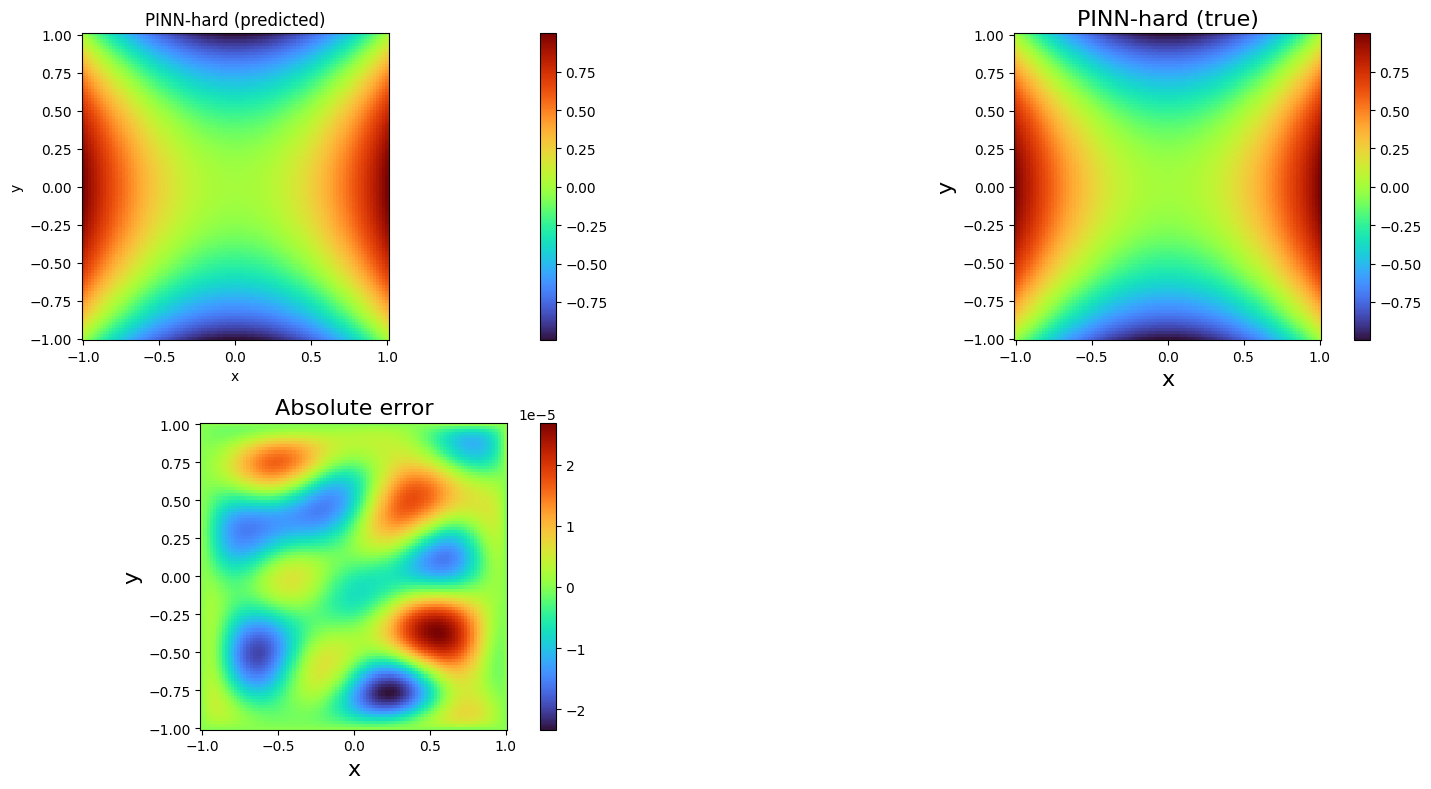

In [14]:
### plotting
plt.figure("", figsize=(16, 8))
#
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

# predicted value by network
S = um(X_T, Y_T)
S = S.numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 1.*S, cmap="turbo")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN-hard (predicted)")
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)

# error ....... true solution ....
TT = x**2 - y**2 - S
#

plt.subplot(222)
plt.pcolormesh(X0, Y0, 1.*S, cmap="turbo")
plt.colorbar(pad=-0.3)
#plt.colorbar()
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.title("PINN-hard (true)", fontsize=16)
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)

# error ....... true solution ....
TT = x**2 - y**2 - S
#
#
plt.subplot(223)
plt.pcolormesh(x, y, TT, cmap="turbo")
plt.colorbar(pad=-0.3)
#plt.colorbar()
plt.title(r"Absolute error",fontsize=16)
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
#plt.savefig("heat01.png")
#




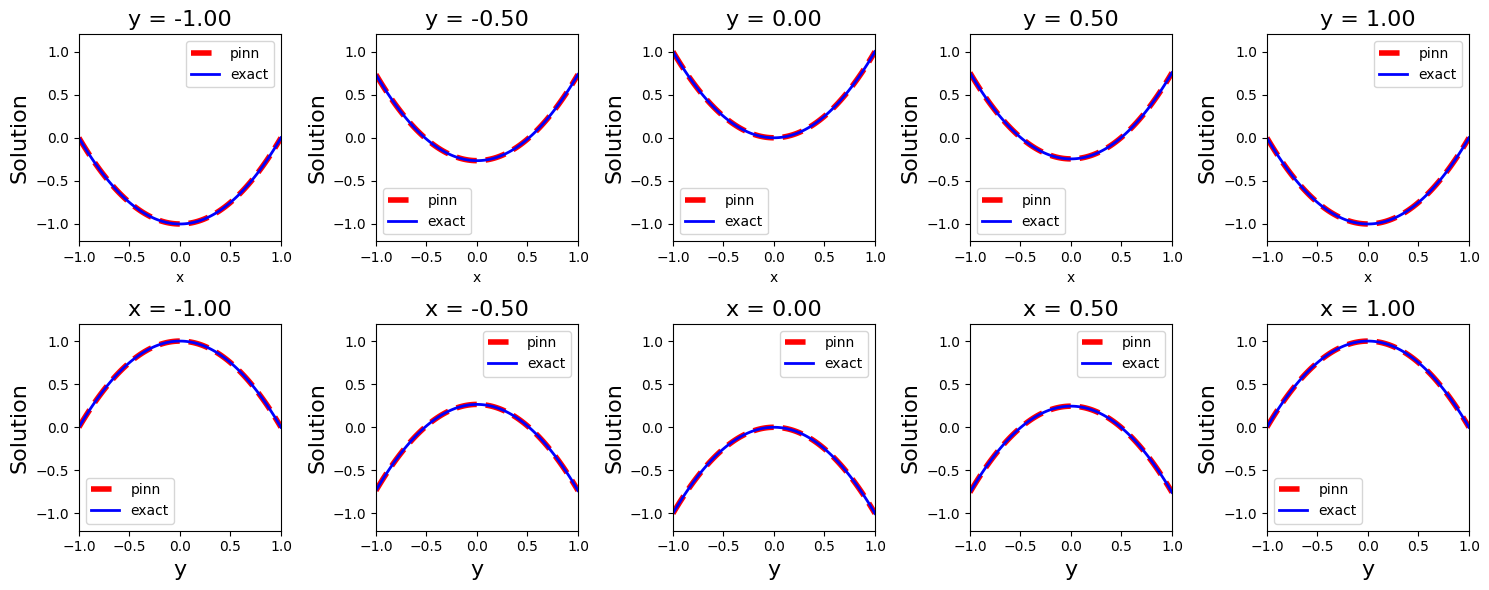

In [15]:
S_ = S.reshape([n, n])
# exact value ...
T_ = x**2-y**2

height = 3
frames_val = np.array([-1, -.5,  0., 0.5, 1.])
frames = [*map(int, (frames_val + 1)/2 * (n-1))]
fig = plt.figure("", figsize=(len(frames)*height, 2*height))

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"y = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(X0[var_index, :], S_[var_index,:], "r--", lw=4., label="pinn")
    plt.plot(X0[var_index, :], T_[var_index,:], "b", lw=2., label="exact")
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1., +1.)
    plt.xlabel("x")
    plt.ylabel("Solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), len(frames) + i+1)
    plt.title(f"x = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(Y0[:, var_index], S_[:,var_index], "r--", lw=4., label="pinn")
    plt.plot(Y0[:, var_index], T_[:,var_index], "b", lw=2., label="exact")
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1., +1.)
    plt.xlabel("y",fontsize=16)
    plt.ylabel("Solution",fontsize=16)
    plt.tight_layout()
    plt.legend()

#plt.savefig("profiles.png")
plt.show()

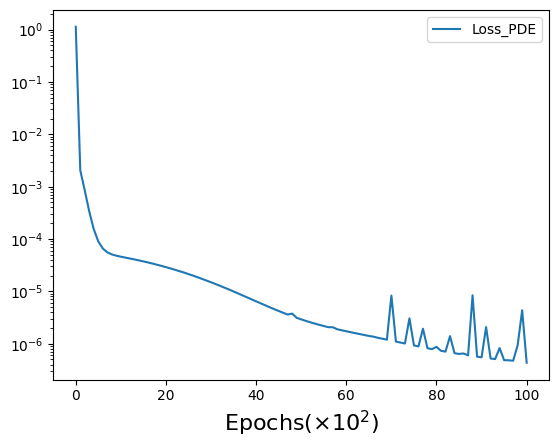

In [18]:
# plt.legend()
#plt.semilogy(l_values, label='data')
# plt.legend()

plt.semilogy(L_values, label='Loss_PDE')
plt.xlabel("Epochs" r'($\times 10^2$)',fontsize=16)
plt.legend()